In [4]:
# Import dependencies
# !pip install wrds # required only first time when this file is run on a system
import wrds
import pandas as pd

  Using cached https://files.pythonhosted.org/packages/1c/35/9d86097c36a8528a1f5bbc3815c161c2dfce7fffc28e10cfd7c9726c1ac0/wrds-3.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ed/2772267467ba5c21a73d37149da0b49a4343c6646d501dbb1450b492d40a/psycopg2_binary-2.8.3-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl


## Setting up connection

In [6]:
db = wrds.Connection(wrds_username='sk1986')
db.create_pgpass_file()
# run this to close connection
# db.close()

Loading library list...
Done
Enter your WRDS username [snehakumari]:sk1986
Enter your password:········


In [92]:
db = wrds.Connection(wrds_username='sk1986') ##run this if you get logged out at any stage -- change this to your username

Loading library list...
Done


List of db funtionc available:
db.close()
db.connection()
db.describe_table()
db.get_table()
db.list_tables()
db.raw_sql()
db.get_row_count()
db.list_libraries()

help(db.get_table)
help(db.raw_sql)

db.get_table('djones', 'djdaily', columns=['date', 'dji'], obs=10)

db.raw_sql('select date,dji from djones.djdaily LIMIT 10;', date_cols=['date'])

## Update sp500 constituents list

#### gvkeyx for S&P500 index is 000003, so we will filter out that in our query
Finding the gvkeyx for sp500 index -- it is located in this
https://wrds-www.wharton.upenn.edu/search_variables/
Query to locate the same if we need to demonstrate:
index_names = db.raw_sql("select * from compd.idx_index")
index_names.head()

In [8]:
index_sp500 = db.raw_sql("SELECT * FROM compd.idxcst_his where gvkeyx = '000003'")

### Collecting data for Cash Flow, Income & Balance sheet items from wrds server

In [9]:
cf_raw = db.raw_sql("""
        SELECT gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,fyr,stalt,aoloch,apalch,aqc,capx,chech,dlcch,dltis,dltr,dpc,dv,esubc,exre,fiao,fincf,fopo,ibc,intpn,invch,ivaco,ivch,ivncf,ivstch,oancf,prstkc,recch,siv,sppe,sppiv,sstk,txach,txdc,txpd,xidoc,exchg,costat 
        FROM compd.funda
        """)

In [10]:
is_raw = db.raw_sql("""
        SELECT gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,fyr,stalt,cogs,cstke,dp,dvp,ib,ibadj,ibcom,mii,ni,niadj,nopi,oiadp,oibdp,pi,sale,spi,txt,xido,xint,xrd,xsga,exchg,costat
        FROM compd.funda
        """)

In [11]:
bs_raw = db.raw_sql("""
        SELECT gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,curncd,fyr,stalt,aco,act,ao,ap,at,ceq,che,dlc,dltt,intan,invt,ivaeq,ivao,lco,lct,lo,lt,mib,ppent,pstk,rect,seq,txditc,txp,exchg
        FROM compd.funda
        """)

##### Clean the files to achieve unique gvkey/year pair. The cleaning filters are the same for the three. 

Following filters are to be applied: 
    
    1) From wrds interface: popsrc = D, consol = C, datafmt = STD
    
    2) From logic: curcd = USD, indfmt != FS

In [12]:
#Filtering cash flow

cf_filtered = cf_raw[cf_raw['curcd']=='USD']
cf_filtered = cf_filtered[cf_filtered['indfmt']!='FS']
cf_filtered = cf_filtered[cf_filtered['datafmt']=='STD']
cf_filtered = cf_filtered[cf_filtered['popsrc']=='D']
cf_filtered = cf_filtered[cf_filtered['consol']=='C']

In [13]:
#Filtering balance sheet

bs_filtered = bs_raw[bs_raw['curcd']=='USD']
bs_filtered = bs_filtered[bs_filtered['indfmt']!='FS']
bs_filtered = bs_filtered[bs_filtered['datafmt']=='STD']
bs_filtered = bs_filtered[bs_filtered['popsrc']=='D']
bs_filtered = bs_filtered[bs_filtered['consol']=='C']

In [14]:
#Filtering income statement

is_filtered = is_raw[is_raw['curcd']=='USD']
is_filtered = is_filtered[is_filtered['indfmt']!='FS']
is_filtered = is_filtered[is_filtered['datafmt']=='STD']
is_filtered = is_filtered[is_filtered['popsrc']=='D']
is_filtered = is_filtered[is_filtered['consol']=='C']

##### One line code for the section below after adding year line --however slightly slow for big dataset

cf = cf_filtered[cf_lastreport = cf_filtered.groupby(['gvkey', 'year'])['datadate'].transform(max)==cf_filtered['datadate']]

In [15]:
# Adding year from datadate to extract last report
cf_filtered['year'] = pd.DatetimeIndex(cf_filtered['datadate']).year

# filtering rows which has the lastreport for that year to get a unique pair of gvkey/year
cf_grouped = cf_filtered.groupby(['gvkey', 'year']).agg({'datadate':'max'})
cf_grouped = cf_grouped.reset_index()
cf_grouped = cf_grouped.rename(columns={'datadate':'lastreport'})
cf = pd.merge(cf_filtered, cf_grouped, how = 'left', on = ['gvkey', 'year'])
cf = cf[cf['datadate'] == cf['lastreport']]

#Check if it yields to unique pair (should return (0,))
cf[cf.duplicated(['gvkey', 'year'], keep=False)].shape

(0, 50)

In [16]:
# Adding year from datadate to extract last report
bs_filtered['year'] = pd.DatetimeIndex(bs_filtered['datadate']).year

# Filtering rows which has the lastreport for that year to get a unique pair of gvkey/year
bs_grouped = bs_filtered.groupby(['gvkey', 'year']).agg({'datadate':'max'})
bs_grouped = bs_grouped.reset_index()
bs_grouped = bs_grouped.rename(columns={'datadate':'lastreport'})
bs = pd.merge(bs_filtered, bs_grouped, how = 'left', on = ['gvkey', 'year'])
bs = bs[bs['datadate'] == bs['lastreport']]

#Check if it yields to unique pair (should return (0,))
bs[bs.duplicated(['gvkey', 'year'], keep=False)].shape

(0, 41)

In [17]:
# Adding year from datadate to extract last report
is_filtered['year'] = pd.DatetimeIndex(is_filtered['datadate']).year

# filtering rows which has the lastreport for that year to get a unique pair of gvkey/year
is_grouped = is_filtered.groupby(['gvkey', 'year']).agg({'datadate':'max'})
is_grouped = is_grouped.reset_index()
is_grouped = is_grouped.rename(columns={'datadate':'lastreport'})
is_d = pd.merge(is_filtered, is_grouped, how = 'left', on = ['gvkey', 'year'])
is_d = is_d[is_d['datadate'] == is_d['lastreport']]

#Check if it yields to unique pair (should return (0,))
is_d[is_d.duplicated(['gvkey', 'year'], keep=False)].shape

(0, 38)

In [18]:
cf.shape

(454173, 50)

In [153]:
# To save the files for export
cf_raw.to_csv('cf_raw.csv')
is_raw.to_csv('is_raw.csv')
bs_raw.to_csv('bs_raw.csv')
cf.to_csv('cf_final.csv')
is_d.to_csv('is_final.csv')
bs.to_csv('bs_final.csv')
index_sp500.to_csv('sp500const.csv')

##### Merge the cleaned files with sp500 file (using gvkey) and filter the rows where the firms were part of sp500 index 

In [19]:
index_sp500.count(axis = 0)

gvkey     1781
iid       1781
gvkeyx    1781
from      1781
thru      1276
dtype: int64

In [20]:
#Arranging index file to get year and adjust current
index_sp500['from_year']= pd.DatetimeIndex(index_sp500['from']).year
index_sp500['to_year']= pd.DatetimeIndex(index_sp500['thru']).year
index_sp500["to_year"].fillna(2019, inplace=True) # replaces blanks as 2019 year

### Merging the data files with index file and then sorting to get unique gvkey datadate pairs

In [21]:
cf_sp500 = pd.merge(cf, index_sp500, how = 'inner', on = ['gvkey'])
cf_sp = cf_sp500[(cf_sp500['year']>=cf_sp500['from_year']) & (cf_sp500['year']<cf_sp500['to_year'])]
cf_sp.drop_duplicates(['gvkey', 'datadate'], keep='first',inplace=True)
cf_sp.sort_values(by=['gvkey','year']).reset_index()
cf_sp[cf_sp.duplicated(['gvkey', 'datadate'], keep=False)].shape

/Users/snehakumari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 56)

In [22]:
bs_sp500 = pd.merge(bs, index_sp500, how = 'inner', on = ['gvkey'])
bs_sp = bs_sp500[(bs_sp500['year']>=bs_sp500['from_year']) & (bs_sp500['year']<bs_sp500['to_year'])]
bs_sp.drop_duplicates(['gvkey', 'datadate'], keep='first',inplace=True)
bs_sp.sort_values(by=['gvkey','year']).reset_index()
bs_sp[bs_sp.duplicated(['gvkey', 'datadate'], keep=False)].shape

/Users/snehakumari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 47)

In [23]:
is_sp500 = pd.merge(is_d, index_sp500, how = 'inner', on = ['gvkey'])
is_sp = is_sp500[(is_sp500['year']>=is_sp500['from_year']) & (is_sp500['year']<is_sp500['to_year'])]
is_sp.drop_duplicates(['gvkey', 'datadate'], keep='first',inplace=True)
is_sp.sort_values(by=['gvkey','year']).reset_index()
is_sp[is_sp.duplicated(['gvkey', 'datadate'], keep=False)].shape

/Users/snehakumari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 44)

## Collapse data by year and sequence it as desired

In [24]:
bs_nominal = bs_sp.groupby('year')['che','rect','invt','aco','act','ppent','ivaeq','ivao','intan','ao','at','dlc','ap','txp','lco','lct','dltt','lo','txditc','mib','lt','pstk','ceq','seq'].sum()
bs_nominal['firm_count']= bs_sp.groupby('year').gvkey.nunique()

In [25]:
is_nominal = is_sp.groupby('year')['sale','cogs','xsga','oibdp','dp','oiadp','xint','nopi','spi','pi','txt','mii','ib','dvp','ibcom','cstke','ibadj','xido','niadj','ni','xrd'].sum()
is_nominal['firm_count']= is_sp.groupby('year').gvkey.nunique()

In [26]:
cf_nominal = cf_sp.groupby('year')['ibc','dpc','xidoc','txdc','esubc','sppiv','fopo','recch','invch','apalch','txach','aoloch','oancf','ivch','siv','ivstch','capx','sppe','aqc','ivaco','ivncf','sstk','prstkc','dv','dltis','dltr','dlcch','fiao','fincf','exre','chech'].sum()
cf_nominal['firm_count']= cf_sp.groupby('year').gvkey.nunique()

In [27]:
#Tranpose the dataframes
cf_nominal = cf_nominal.transpose() 
is_nominal = is_nominal.transpose()
bs_nominal = bs_nominal.transpose()

In [29]:
cf_nominal.head()

year,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
ibc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25657.248,31259.235,44663.531,...,508484.931,771795.310,886844.517,856770.876,990436.940,985981.035,859660.825,908283.718,1049283.023,1159666.291
dpc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25092.648,27930.352,33265.599,...,460597.401,468622.859,494411.512,522737.685,546280.763,569042.876,630134.422,627839.161,659460.831,683014.812
xidoc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.978,485.624,627.298,...,12856.445,12230.449,7272.026,7910.742,2780.375,3765.503,13048.327,-7924.309,-436.555,223.759
txdc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1567.940,2278.328,4303.388,...,2604.536,36288.759,30756.429,25088.180,42879.676,31768.118,-31110.180,11134.389,-55740.294,-53632.139
esubc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-497.374,-810.275,-950.993,...,-410.038,-5966.603,-2520.133,-7615.653,-8814.837,-10508.104,-2219.747,-2822.162,-4213.460,-2884.740


In [28]:
# Save files to single file
# !pip install xlsxwriter #required to run only first time
import xlsxwriter

writer = pd.ExcelWriter('sp500_nominal.xlsx', engine='xlsxwriter')

cf_nominal.to_excel(writer, sheet_name='CashFlow')
is_nominal.to_excel(writer, sheet_name='IncomeSt')
bs_nominal.to_excel(writer, sheet_name='BalanceSheet')

writer.save()

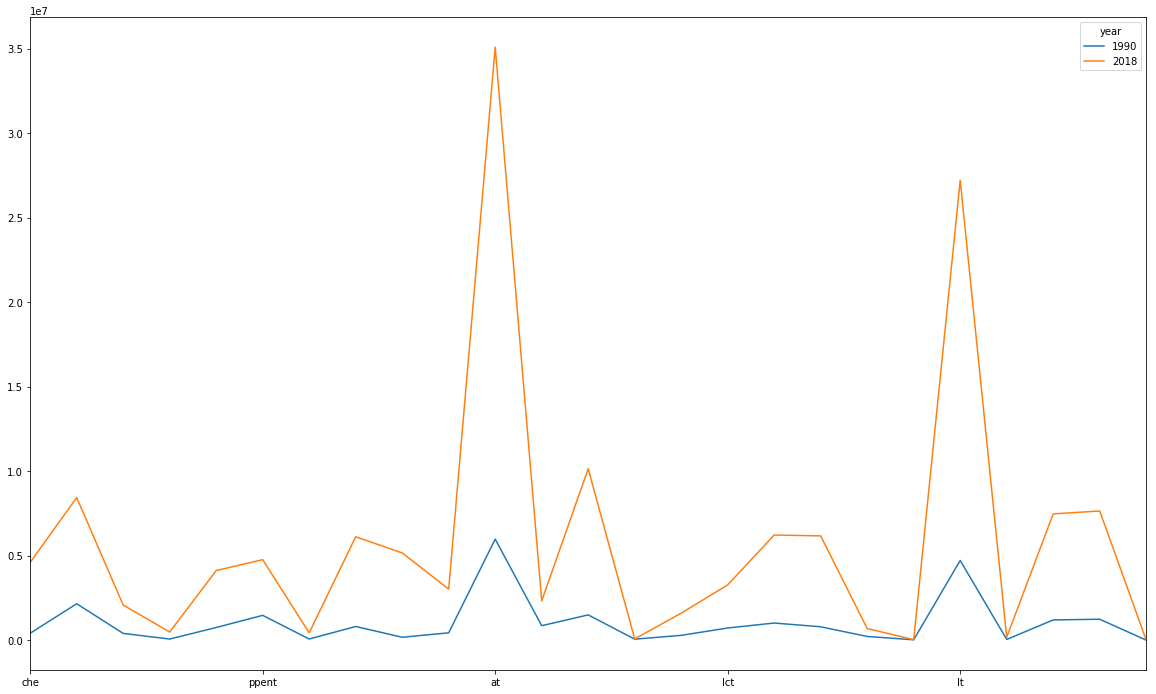

In [39]:
bs_nominal.plot(y=[1990, 2018], kind = 'line', figsize=(20,12))

### WIP : run cpi index to get the real value as per 2009 data

In [271]:
len(bs_nominal.index)

55

In [266]:
x=0
y=1964
bs_nominal['cpi2009'] = None
# 

In [267]:
for rows in bs_nominal.index:
    bs_nominal['cpi2009']=cpi.inflate(100,2009,to=y)
    x+=1
    y+=1

In [274]:
bs_nominal.head()

,che,rect,invt,aco,act,ppent,ivaeq,ivao,intan,ao,...,dltt,lo,txditc,mib,lt,pstk,ceq,seq,firm_count,cpi2009
year,,,,,,,,,,,,,,,,,,,,,
1964,27442.336,41708.533,42793.750,896.172,115863.171,169132.352,9057.448,4549.275,1588.047,4774.572,...,61961.056,4596.522,5183.309,2972.954,121440.119,6600.878,122014.505,128740.249,426,117.046011
1965,28193.630,47960.408,48008.429,1357.764,128488.672,186033.580,9839.833,5043.460,1998.899,5120.808,...,68393.845,4920.275,5976.591,3296.943,137842.405,6779.377,140288.617,147303.012,440,117.046011
1966,25695.608,55323.221,55282.653,1724.494,141449.216,211183.899,11295.508,5790.974,2355.527,5044.404,...,81047.694,5865.358,6444.649,3640.096,161560.018,6947.436,189001.286,196118.587,453,117.046011
1967,26202.156,61041.472,60625.755,2133.738,153415.476,237098.590,12074.026,6993.327,2989.269,5811.203,...,95405.602,7271.641,7594.289,4380.477,184442.761,7801.560,210449.084,218398.834,458,117.046011
1968,29747.677,68362.112,65591.833,3469.659,170695.857,263296.083,15342.247,7384.905,3460.072,7096.320,...,108652.298,7303.308,10713.114,4942.243,214578.322,8507.702,231512.797,240006.781,472,117.046011
